In [4]:
import pandas as pd
from fake_useragent import UserAgent
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from bs4 import BeautifulSoup

In [5]:
movies = pd.read_csv("dataset.csv")

In [6]:
movies.head()

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count
0,278,The Shawshank Redemption,"Drama,Crime",en,Framed in the 1940s for the double murder of h...,94.075,1994-09-23,8.7,21862
1,19404,Dilwale Dulhania Le Jayenge,"Comedy,Drama,Romance",hi,"Raj is a rich, carefree, happy-go-lucky second...",25.408,1995-10-19,8.7,3731
2,238,The Godfather,"Drama,Crime",en,"Spanning the years 1945 to 1955, a chronicle o...",90.585,1972-03-14,8.7,16280
3,424,Schindler's List,"Drama,History,War",en,The true story of how businessman Oskar Schind...,44.761,1993-12-15,8.6,12959
4,240,The Godfather: Part II,"Drama,Crime",en,In the continuing saga of the Corleone crime f...,57.749,1974-12-20,8.6,9811


In [7]:
# Combine genre and overview to create tags
movies['tags'] = movies['genre'] +" " +movies['overview']

In [8]:
# Select relevant columns
new_df = movies[['title', 'tags']]

In [9]:
new_df.head()

,title,tags
0,The Shawshank Redemption,"Drama,Crime Framed in the 1940s for the double..."
1,Dilwale Dulhania Le Jayenge,"Comedy,Drama,Romance Raj is a rich, carefree, ..."
2,The Godfather,"Drama,Crime Spanning the years 1945 to 1955, a..."
3,Schindler's List,"Drama,History,War The true story of how busine..."
4,The Godfather: Part II,"Drama,Crime In the continuing saga of the Corl..."


In [10]:
cv = CountVectorizer(max_features=10000,stop_words='english')

In [11]:
def build(index):
    # Recalculate cosine similarity
    vec = cv.fit_transform(new_df['tags'].values.astype('U')).toarray()
    sim = cosine_similarity(vec)
    # Get the similarity scores
    dist = sorted(list(enumerate(sim[index])), reverse=True, key=lambda x: x[1])
    # Recommend top 5 similar movies
    print(new_df.iloc[index]['tags'])
    for i in dist[1:6]:
        print(new_df.iloc[i[0]]['title'])

In [12]:
def search_and_recommend(movie):
    query = movie + " movie overview"
    print(query)
    ua = UserAgent()
    user_agent = ua.random  # Generate a random user agent
    headers = {"User-Agent": user_agent}
    response = requests.get("https://www.bing.com/search?q="+query, headers=headers)
    print(response.text)
    tag = ""  # Initialize overview to empty string
    soup = BeautifulSoup(response.text,'html.parser')
    soup1 = BeautifulSoup(requests.get("https://www.bing.com/search?q="+movie+" movie genre",headers=headers).text,'html.parser')
    
    i = 0
    while(True):
        sr1 = soup1.select('[class^="tit"]')
        if sr1:
            print(sr1)
            for ele in sr1:
                tag+=ele.get_text(strip=True)+" "
            break;
        i+=1
        if i>100:
            print("NO result")
            return;
    i = 0
    while(True):
        sr2 = soup.select('[class^="rwrl"]')
        if sr2:
            print(sr2)
            for ele in sr2:
                tag+=ele.get_text(strip=True)
            break;
        i+=1
        if i>100:
            print("No Result")
            break;
    
    # Add the overview to the dataset
    new_movie_row = {'title': movie, 'tags': tag}
    new_df.loc[len(new_df)] = new_movie_row
    # Recalculate cosine similarity
    vec = cv.fit_transform(new_df['tags'].values.astype('U')).toarray()
    sim = cosine_similarity(vec)
    # Get the index of the newly added movie
    index = len(new_df) - 1
    build(index)
    

In [13]:

def recommend(movie):
    # Check if the movie is in the dataset
    if movie in new_df['title'].values:
        index = new_df[new_df['title'] == movie].index[0]
        build(index)

    else:
        # If movie is not in dataset, search for its overview on Google
        search_and_recommend(movie)


Alluri Seetha Rama Raju 1974 movie overview
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd"><html dir="ltr" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:Web="http://schemas.live.com/Web/"><script type="text/javascript" >//<![CDATA[
si_ST=new Date
//]]></script><head><!--pc--><title>Alluri Seetha Rama Raju 1974 movie overview - Search</title><meta content="text/html; charset=utf-8" http-equiv="content-type" /><meta name="viewport" content="width=device-width, minimum-scale=1.0, initial-scale=1.0, maximum-scale=1.0, user-scalable=no" /><meta name="referrer" content="origin-when-cross-origin" /><meta name="format-detection" content="telephone=no" /><meta name="mobileoptimized" content="0" /><meta property="og:description" content="Intelligent search from Bing makes it easier to quickly find what you’re looking for and rewards you." /><meta property="og:site_name" content="Bing" /><meta property=
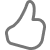
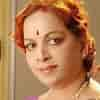
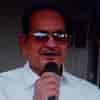
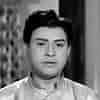
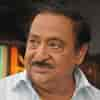
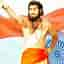

In [14]:
recommend("Alluri Seetha Rama Raju 1974")

In [25]:
print("After")
new_df.tail()

After


,title,tags
9995,The Last Airbender,"Action,Adventure,Fantasy The story follows the..."
9996,Sharknado 3: Oh Hell No!,"Action,TV Movie,Science Fiction,Comedy,Adventu..."
9997,Captain America,"Action,Science Fiction,War During World War II..."
9998,In the Name of the King: A Dungeon Siege Tale,"Adventure,Fantasy,Action,Drama A man named Far..."
9999,Domino,"Thriller,Action,Crime Seeking justice for his ..."


In [26]:
new_df.drop(10000,axis=0,inplace=True)

KeyError: '[10000] not found in axis'